In [6]:
import numpy as np
import pandas as pd
import pyreadr
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

from natsort import natsorted
from glob import glob
import pickle
import os
from os.path import basename, splitext
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from scipy.stats import multivariate_normal
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
pd.set_option('display.max_columns', 40)
sns.set_theme(context='notebook', style='ticks')

from utils.shift import *
from utils.age import *
from utils.vis import plot_performance_scatter, plot_repr_uncertainty, plot_covariate_panel

%load_ext autoreload
%autoreload 2

#load published mouse clocks
clocks = pickle.load(open('subdata/clock_coefs_mouse.pkl', 'rb'))
cname = 'Thompson'
clock = clocks[cname]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# GSE120132 <-> GSE121141 (Aging liver: Thompson - Meer)

In [7]:
#Aging (Thompson) https://www.aging-us.com/article/101590/text
met1 = pickle.load(open('data/GSE120132/GSE120132_metlevs_processed_annotated.pkl', 'rb'))
dfa = met1.drop(['Strain', 'Tissue', 'Age', 'Sex', 'ID'], axis=1).T
meta = met1[['ID', 'Strain', 'Tissue', 'Sex']].copy()
meta['age'] = met1['Age']
dfa = dfa[meta.index]

#Reprogramming + controls (Serrano)
met2 = pickle.load(open('data/GSE121141/GSE121141_metlevs_processed_annotated.pkl', 'rb'))
dfr = met2.drop(['Strain', 'Tissue', 'Age', 'Sex'], axis=1).T
metr = met2[['Strain', 'Tissue', 'Sex']].copy()
metr['age'] = met2['Age']
dfr = dfr[metr.index]

# choose tissue from: ['Liver', None]
tissue_age = 'Liver'

if tissue_age is not None:
    meta = meta[meta['Tissue'] == tissue_age]
    dfa = dfa[meta.index].dropna(axis=0)
    metr = metr[metr['Tissue'] == tissue_age]
    dfr = dfr[metr.index].dropna(axis=0)

print('Age 1, N sites', len(dfa.index))
print('Age 2, N sites', len(dfr.index))

Age 1, N sites 1113442
Age 2, N sites 1351293


## Select sites using best Lasso model for de-novo clocks

19384 common sites
R2 train = 0.9966904964657989
R2 test = 0.7699156138224014
MAE train = 0.2946861157785617
MAE test = 3.540421953488014
------------------------------


/home/shappiron/Desktop/CAL/reprogramming_ood/utils/vis.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


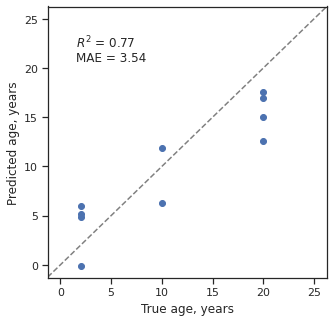

In [5]:
#select de-novo sites
sites = dfr.index.intersection(dfa.index)
print(f"{len(sites)} common sites")

Xa_clock = dfa.loc[sites].T
Xr_clock = dfr.loc[sites].T

ya = meta['age']
yr = metr['age']

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.33, random_state=10)

### TRAINING ###
from sklearn.linear_model import LassoCV
         
model = LassoCV(n_jobs=-1)
model.fit(X_train, y_train)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

print(f'R2 train = {r2_score(y_train, y_train_predict)}')
print(f'R2 test = {r2_score(y_test, y_test_predict)}')
print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')
print('-'*30)

# write coefs
lasso_sites = model.feature_names_in_[model.coef_ != 0]
lasso_coef = model.coef_[model.coef_ != 0]
clock = pd.DataFrame({'coef':lasso_coef}, index=lasso_sites)

plot_performance_scatter(y_test, y_test_predict, eq_bounds=(0, 25))

In [77]:
y_rep_predict = model.predict(Xr_clock)

In [81]:
metr['lasso_age'] = y_rep_predict

<AxesSubplot:xlabel='characteristics_ch1.2.cell type', ylabel='lasso_age'>

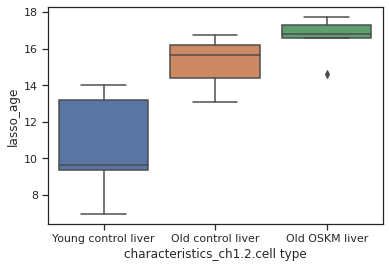

In [84]:
sns.boxplot(data=metr, x='characteristics_ch1.2.cell type', y='lasso_age')

In [141]:
# clock.index.intersection(dfr.index)

# idx = clock.index

# new_index = []
# for s in idx:
#     c, p = s.split('_')
#     new_index.append(c + '_' + str(int(p)))

# len(dfr.index.intersection(new_index)  )

In [134]:

# filt = ['Fibroblast', 'Transient reprogramming intermediate', 'iPSC']
# cond = metr['Condition'].isin(filt)

# metr = metr[cond]
# dfr = dfr.loc[:, cond]
# methclock = methclock[cond].dropna(axis=1)
# print(metr['Condition'].unique())

# groupr = methclock.groupby('age').mean()

# repday0 = 0
# repday1 = 17

## Check covariate shift

In [8]:
sites = clock.index.intersection(dfr.index).intersection(dfa.index)
print(f"{len(sites)} common sites")

Xa_clock = dfa.loc[sites].T
Xr_clock = dfr.loc[sites].T

ya = meta['age']
yr = metr['age']

300 common sites


98.67% of sites are not rejected by KS test


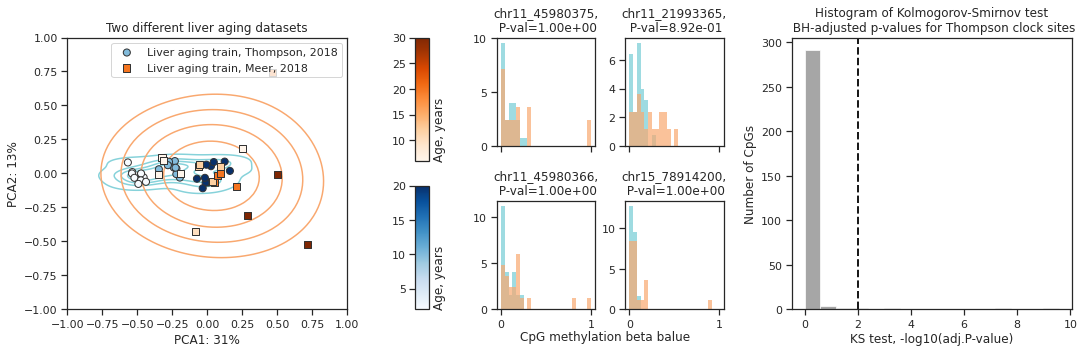

In [10]:

plot_covariate_panel(Xa_clock, Xr_clock, ya, yr,
                        cbar_color_train = 'Blues',
                        cbar_color_test = 'Oranges',
                        color_train = '#86d2da',
                        color_test = '#f9a86f',
                        xa_thr=0.05,
                        xr_thr=0.5,
                        cbar_label_train = 'Age, years',
                        cbar_label_test = 'Age, years',
                        legend_label_train = 'Liver aging train, Thompson, 2018',
                        legend_label_test ='Liver aging train, Meer, 2018',
                        ks_hist_title = 'Histogram of Kolmogorov-Smirnov test\n BH-adjusted p-values for Thompson clock sites',
                        pca_title = 'Two different liver aging datasets',
                        pca_legend_pos = 'upper right',
                        pca_xlim = [-1, 1.0], #pca_xlim = [-2.7, 5.0],
                        pca_ylim = [-1, 1.0]  #pca_ylim = [-1.5, 5.0]                   
                        )

plt.savefig('figs/A1_sup_aging_liver.pdf', format='pdf', bbox_inches='tight')
plt.show()

/home/shappiron/anaconda3/lib/python3.9/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))
/tmp/ipykernel_8479/2862108564.py:67: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig('figs/A1_suppl_aging_liver.pdf', format='pdf', bbox_inches='tight')


99.0% of sites not rejected by KS test


/tmp/ipykernel_8479/2862108564.py:67: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig('figs/A1_suppl_aging_liver.pdf', format='pdf', bbox_inches='tight')
/home/shappiron/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


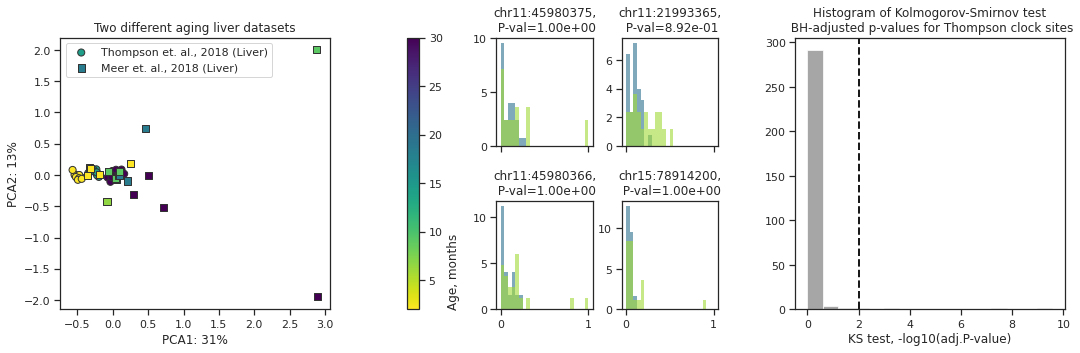

In [6]:
# from matplotlib.gridspec import GridSpec
# import matplotlib as mpl

# fig = plt.figure(figsize=(18, 5), constrained_layout=True)
# gs = GridSpec(2, 7, figure=fig, width_ratios=[4, 4, 0.5, 3, 3, 4, 4], wspace=1.0, hspace=0.5) 

# axcb = fig.add_subplot(gs[:, 2])

# minihists = gs[:, 3:5].subgridspec(2, 2, wspace=0.3, hspace=0.5)
# minihist_subs = minihists.subplots(sharex=True)
# ax0 = fig.add_subplot(gs[:, :2])
# ax1 = minihist_subs[0,0]
# ax2 = minihist_subs[0,1]
# ax3 = minihist_subs[1,0]
# ax4 = minihist_subs[1,1]
# ax5 = fig.add_subplot(gs[:, 5:])

# #cbars
# cmap_age = mpl.cm.viridis_r
# norm_age = mpl.colors.Normalize(vmin=min(min(ya), min(yr)), vmax=max(max(ya), max(yr)))
# cb_age = mpl.colorbar.ColorbarBase(axcb, cmap=cmap_age, norm=norm_age)
# cb_age.set_label('Age, months', loc='bottom')

# # ax0 - PCA
# ax0.set_title('Two different aging liver datasets')
# z1_plot = ax0.scatter(Xpa[:, 0], Xpa[:, 1], c=ya, s=50, label='Thompson et. al., 2018 (Liver)', 
#                       edgecolors='#333333', cmap=cmap_age)
# z2_plot = ax0.scatter(Xpr[:, 0], Xpr[:, 1], c=yr, marker='s', s=50, label='Meer et. al., 2018 (Liver)', 
#                       edgecolors='#333333', cmap=cmap_age)
# ax0.set_xlabel(f'PCA1: {int(pvar[0]*100)}%')
# ax0.set_ylabel(f'PCA2: {int(pvar[1]*100)}%')
# ax0.legend()

# # ax5 - overall KS pvalues hist
# ks, ksp = calculate_shift(np.array(Xa_clock), np.array(Xr_clock), metric_type='ks')
# kspa = multipletests(ksp, method='hs')[1]
# kspa = pd.DataFrame(index=Xa_clock.columns, data={'pval':kspa})

# kspaval = -np.log10(kspa['pval'].values)
# kspaval = np.where(kspaval < 20, kspaval , 20)
# pct = round((kspaval < 2).sum() / kspaval.shape[0], 2) * 100
# print(f'{pct}% of sites not rejected by KS test')

# ax5.set_title('Histogram of Kolmogorov-Smirnov test\n BH-adjusted p-values for Thompson clock sites')
# ax5.hist(kspaval, density=False, alpha=0.7, color='grey', bins=16)
# ax5.axvline(-np.log10(0.01), color='k', ls='--', lw=2.0)
# # ax5.set_xlim([0, 2.5])
# ax5.set_xlabel('KS test, -log10(adj.P-value)')

# #top sites from Skin clock based on correlation with age
# selected_sites = Xa_clock.corrwith(ya).abs().sort_values(ascending=False).index[:4]

# #examples of sites + PSIs
# for k, ax_ in enumerate([ax1, ax2, ax3, ax4]): 
#     site_pval = kspa.loc[selected_sites[k], 'pval']
#     ax_.hist(Xa_clock[selected_sites[k]], density=True, alpha=0.6, 
#              color='#2c718e', 
#              bins=np.linspace(0, 1, 25), 
#              edgecolor='none')
#     ax_.hist(Xr_clock[selected_sites[k]], density=True, alpha=0.6, 
#              color='#a3da36', 
#              bins=np.linspace(0, 1, 25), 
#              edgecolor='none')
#     ax_.set_title(f'{selected_sites[k].replace("_", ":")},\n P-val={"{0:.2e}".format(site_pval)}')
#     ax_.set_xlim([-0.05, 1.05])

# plt.savefig('figs/A1_suppl_aging_liver.pdf', format='pdf', bbox_inches='tight')
# plt.show()

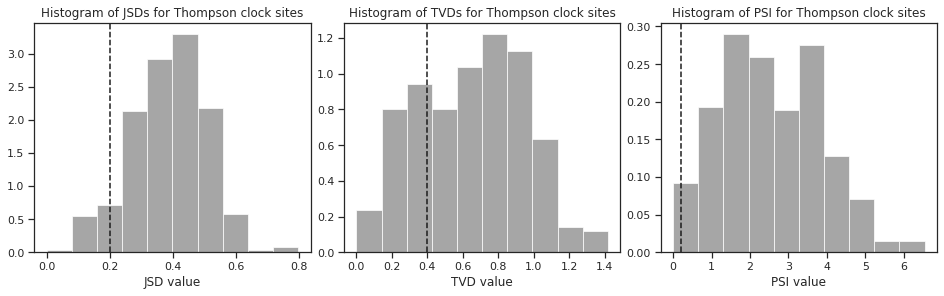

In [42]:
#supplement

fig = plt.figure(figsize=(13, 4), constrained_layout=True)
gs = GridSpec(1, 3, figure=fig) 
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])

# ax5 - overall PSI hist
jsds = calculate_shift(np.array(Xa_clock), np.array(Xr_clock), metric_type='jsd')

ax0.set_title('Histogram of JSDs for Thompson clock sites')
ax0.hist(jsds, density=True, alpha=0.7, color='grey')
ax0.axvline(0.2, color='k', ls='--')
# ax0.set_xlim([0, 0.5])
ax0.set_xlabel('JSD value')

tvds = calculate_shift(np.array(Xa_clock), np.array(Xr_clock), metric_type='tvd')

ax1.set_title('Histogram of TVDs for Thompson clock sites')
ax1.hist(tvds, density=True, alpha=0.7, color='grey')
ax1.axvline(0.4, color='k', ls='--')
# ax1.set_xlim([0, 1])
ax1.set_xlabel('TVD value')

psis = calculate_shift(np.array(Xa_clock), np.array(Xr_clock), metric_type='psi')

ax2.set_title('Histogram of PSI for Thompson clock sites')
ax2.hist(psis, density=True, alpha=0.7, color='grey')
ax2.axvline(0.2, color='k', ls='--')
# ax2.set_xlim([0, 1.0])
ax2.set_xlabel('PSI value')

plt.savefig('figs/A1_sup_aging_liver_metrics.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Inversed Train Test Procedure (ITTP)

In [43]:
# Thompson clocks
sites = clock.index.intersection(dfr.index).intersection(dfa.index)
print(f"{len(sites)} common sites")

Xa_clock = dfa.loc[sites].T
Xr_clock = dfr.loc[sites].T

ya = meta['age']
yr = metr['age']

300 common sites


Step 1 results:
R2 train = 0.971
MAE train = 1.023
R2 test = -0.055
MAE test = 6.144
------------------------------
Step 2 results:
R2 train = -0.053
MAE train = 6.14
R2 test = 0.933
MAE test = 1.488
------------------------------


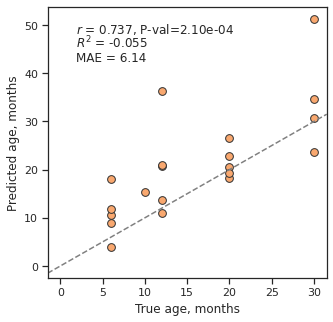

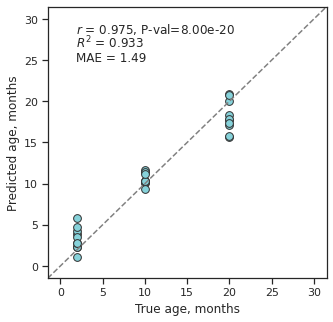

In [47]:
# Thompson -> Meer
from warnings import filterwarnings
filterwarnings('ignore')
from sklearn.linear_model import LassoCV
(y_train_predict_step1, 
 y_test_predict_step1, 
 y_train_predict_step2,
 y_test_predict_step2) = inverse_train_test_procedure(LassoCV, 
                                 Xa_clock, ya, 
                                 Xr_clock, y_test=yr, 
                                 params={"max_iter":3000},
                                 verbose=0)

plot_performance_scatter(yr, y_test_predict_step1, eq_bounds=(0, 30), color='#f9a86f', markersize=60, units='months')
plt.savefig('figs/A3_aging_liver_thompson_meer_step1.pdf', format='pdf', bbox_inches='tight')
plt.show()

plot_performance_scatter(ya, y_test_predict_step2, eq_bounds=(0, 30), color='#86d2da', markersize=60, units='months')
plt.savefig('figs/A3_aging_liver_thompson_meer_step2.pdf', format='pdf', bbox_inches='tight')
plt.show()

Step 1 results:
R2 train = 1.0
MAE train = 0.041
R2 test = 0.511
MAE test = 3.931
------------------------------
Step 2 results:
R2 train = 0.51
MAE train = 3.916
R2 test = 0.813
MAE test = 2.446
------------------------------


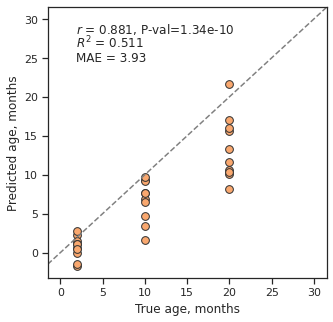

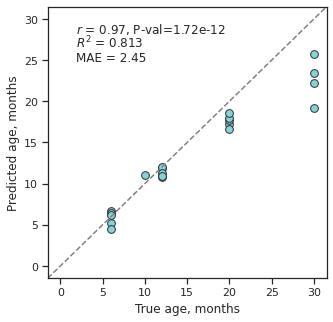

In [46]:
# Meer -> Thompson
(y_train_predict_step1, 
 y_test_predict_step1, 
 y_train_predict_step2,
 y_test_predict_step2) = inverse_train_test_procedure(LassoCV, 
                                 Xr_clock, yr, 
                                 Xa_clock, y_test=ya, 
                                 params={"max_iter":3000},
                                 verbose=0)

plot_performance_scatter(ya, y_test_predict_step1, eq_bounds=(0, 30), color='#f9a86f', markersize=60, units='months')
plt.savefig('figs/A3_aging_liver_meer_thompson_step1.pdf', format='pdf', bbox_inches='tight')
plt.show()

plot_performance_scatter(yr, y_test_predict_step2, eq_bounds=(0, 30), color='#86d2da', markersize=60, units='months')
plt.savefig('figs/A3_aging_liver_meer_thompson_step2.pdf', format='pdf', bbox_inches='tight')
plt.show()

## Epistemic uncertainty estimation with Gaussian Process Regressor

### Thompson -> Meer

300 common sites
R2 train = 0.9999893306057938
R2 test = 0.7849104381698779
MAE train = 0.018378980695724776
MAE test = 2.755163030656922
------------------------------
Resulting kernel: 17.3**2 * RBF(length_scale=3.17) + WhiteKernel(noise_level=0.1)


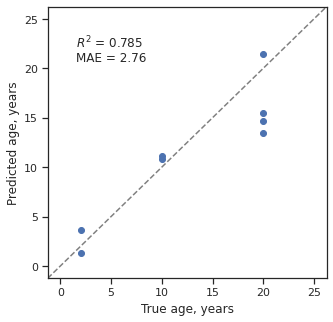

In [182]:
sites = clock.index.intersection(dfr.index).intersection(dfa.index)
print(f"{len(sites)} common sites")

Xa_clock = dfa.loc[sites].T
Xr_clock = dfr.loc[sites].T

ya = meta['age']
yr = metr['age']

X_train, X_test, y_train, y_test = train_test_split(Xa_clock, ya, test_size=0.25, random_state=10)


### TRAINING ###
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

# kernel = 1 * DotProduct(sigma_0=1, sigma_0_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
         
model = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=3)
model.fit(X_train, y_train)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

print(f'R2 train = {r2_score(y_train, y_train_predict)}')
print(f'R2 test = {r2_score(y_test, y_test_predict)}')
print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')
print('-'*30)
print("Resulting kernel:", model.kernel_)

plot_performance_scatter(y_test, y_test_predict, eq_bounds=(0, 25))

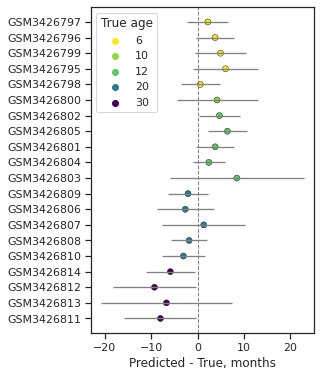

R2 test = 0.6553301651618466
MAE test = 4.422922488438509


In [183]:
import matplotlib as mpl
import matplotlib.cm as cm

#prediction of test dataset
y_test_predict_r, y_test_std_r = model.predict(Xr_clock, return_std=True)

metr['gpr_age'] = y_test_predict_r
metr['gpr_std'] = y_test_std_r
metr['diff'] = metr['gpr_age'] - metr['age']
   
fig, ax = plt.subplots(1,1, figsize=(4, 6))
metr_ = metr.copy().reset_index().sort_values('age')

sns.scatterplot(
    data=metr_, x="diff", y='index',  
    marker="o",
    hue='age',
    edgecolor='k',
    palette=mpl.cm.viridis_r,
    ax=ax
)

ax.errorbar(x=metr_['diff'], y=metr_['index'], xerr=metr_['gpr_std'], linewidth=0, elinewidth=1.3, color='grey')
ax.axvline(0, ls='--', lw=1, color='grey')
ax.set_xlabel('Predicted - True, months')
ax.set_ylabel('')
ax.legend(title='True age', loc='upper left')
plt.show()

print(f'R2 test = {r2_score(yr, y_test_predict_r)}')
print(f'MAE test = {mean_absolute_error(yr, y_test_predict_r)}')

### Meer -> Thompson

300 common sites
R2 train = 0.9999967371804833
R2 test = 0.4590653669793703
MAE train = 0.012713238695654857
MAE test = 5.545592427805215
------------------------------
Resulting kernel: 19.4**2 * RBF(length_scale=3.22) + WhiteKernel(noise_level=0.1)


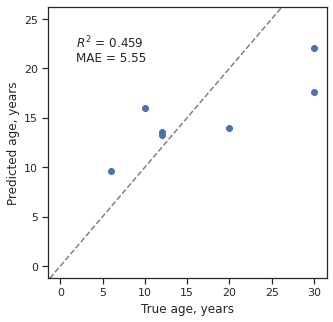

In [179]:
sites = clock.index.intersection(dfr.index).intersection(dfa.index)
print(f"{len(sites)} common sites")

Xa_clock = dfa.loc[sites].T
Xr_clock = dfr.loc[sites].T

ya = meta['age']
yr = metr['age']

X_train, X_test, y_train, y_test = train_test_split(Xr_clock, yr, test_size=0.33, random_state=10)


### TRAINING ###
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel, RBF

# kernel = 1 * DotProduct(sigma_0=1, sigma_0_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
kernel = 1 * RBF(length_scale=1, length_scale_bounds=(1e-2, 100)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-1, 100))
         
model = GaussianProcessRegressor(kernel=kernel, normalize_y=False, n_restarts_optimizer=3)
model.fit(X_train, y_train)

y_train_predict = model.predict(X_train)
y_test_predict = model.predict(X_test)

print(f'R2 train = {r2_score(y_train, y_train_predict)}')
print(f'R2 test = {r2_score(y_test, y_test_predict)}')
print(f'MAE train = {mean_absolute_error(y_train, y_train_predict)}')
print(f'MAE test = {mean_absolute_error(y_test, y_test_predict)}')
print('-'*30)
print("Resulting kernel:", model.kernel_)

plot_performance_scatter(y_test, y_test_predict, eq_bounds=(0, 25))

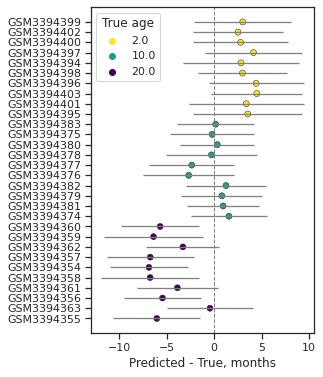

R2 test = 0.7276787146898644
MAE test = 3.206561450006608


In [181]:
import matplotlib as mpl
import matplotlib.cm as cm

#prediction of test dataset
y_test_predict_r, y_test_std_r = model.predict(Xa_clock, return_std=True)

meta['gpr_age'] = y_test_predict_r
meta['gpr_std'] = y_test_std_r
meta['diff'] = meta['gpr_age'] - meta['age']
   
fig, ax = plt.subplots(1,1, figsize=(4, 6))
meta_ = meta.copy().reset_index().sort_values('age')

sns.scatterplot(
    data=meta_, x="diff", y='index',  
    marker="o",
    hue='age',
    edgecolor='k',
    palette=mpl.cm.viridis_r,
    ax=ax
)

ax.errorbar(x=meta_['diff'], y=meta_['index'], xerr=meta_['gpr_std'], linewidth=0, elinewidth=1.3, color='grey')
ax.axvline(0, ls='--', lw=1, color='grey')
ax.set_xlabel('Predicted - True, months')
ax.set_ylabel('')
ax.legend(title='True age', loc='upper left')
plt.show()

print(f'R2 test = {r2_score(ya, y_test_predict_r)}')
print(f'MAE test = {mean_absolute_error(ya, y_test_predict_r)}')